In [64]:
import numpy as np 
import pandas as pd 
import multiprocessing as multi
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time
from astropy.cosmology import Planck18 as cosmo
from scipy.stats import skew
from scipy.stats import kurtosis
import plotly.express as px

In [2]:
%%capture PC_name 
!hostname

**Setting notebook parameters**

In [3]:
#setting dots per inch for images
dpi = 90

#setting number of processors for multiprocessing
PC_name_str = PC_name.stdout[0:-2]

if (PC_name_str == 'arc10'or PC_name_str == 'science11' or 
        PC_name_str == 'science10'):
    cores = 84        
#     cores = multi.cpu_count()
    
else:
    cores = multi.cpu_count()

print(PC_name_str)
print(cores)

arc10
84


In [4]:
df_sdss_gals = pd.read_csv('../codes_for_SDSS/Data/SAS_FITS/galaxy_DR12v5_CMASSLOWZTOT_all_sky_Comov.csv',
                         index_col = 0)
df_sdss_gals.describe().apply(lambda s: s.apply('{0:.3f}'.format))

/vol/arc10/data1/amirza/Misc/anaconda/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


RA          DEC            Z r_comov[Mpc/h] X_comov[Mpc/h]  \
count  1325735.000  1325735.000  1325735.000    1325735.000    1325735.000   
mean       178.676       23.417        0.452       1188.863       -272.192   
std         92.194       18.180        0.157        377.180        899.294   
min          0.000      -10.997        0.000          0.015      -2286.040   
25%        135.845        8.361        0.347        953.931       -938.263   
50%        181.891       21.477        0.486       1285.598       -563.199   
75%        227.366       35.940        0.563       1458.133        539.205   
max        359.999       68.738        1.137       2518.253       2244.442   

      Y_comov[Mpc/h] Z_comov[Mpc/h]  
count    1325735.000    1325735.000  
mean         -34.199        447.124  
std          578.618        370.074  
min        -1975.692       -368.732  
25%         -450.408        140.810  
50%          -15.135        387.832  
75%          382.666        703.085  
max         1941.727       2033.417

In [5]:
df_sdss_gals['X_comov[kpc/h]'] = df_sdss_gals['X_comov[Mpc/h]']*1e3
df_sdss_gals['Y_comov[kpc/h]'] = df_sdss_gals['Y_comov[Mpc/h]']*1e3
df_sdss_gals['Z_comov[kpc/h]'] = df_sdss_gals['Z_comov[Mpc/h]']*1e3
df_sdss_gals.describe()

RA           DEC             Z  r_comov[Mpc/h]  \
count  1.325735e+06  1.325735e+06  1.325735e+06    1.325735e+06   
mean   1.786756e+02  2.341721e+01  4.519571e-01    1.188863e+03   
std    9.219390e+01  1.817975e+01  1.565052e-01    3.771801e+02   
min    9.090666e-05 -1.099717e+01  4.893557e-06    1.467050e-02   
25%    1.358452e+02  8.360693e+00  3.474941e-01    9.539314e+02   
50%    1.818909e+02  2.147713e+01  4.862676e-01    1.285598e+03   
75%    2.273659e+02  3.593965e+01  5.633048e-01    1.458133e+03   
max    3.599986e+02  6.873770e+01  1.136586e+00    2.518253e+03   

       X_comov[Mpc/h]  Y_comov[Mpc/h]  Z_comov[Mpc/h]  X_comov[kpc/h]  \
count    1.325735e+06    1.325735e+06    1.325735e+06    1.325735e+06   
mean    -2.721915e+02   -3.419912e+01    4.471238e+02   -2.721915e+05   
std      8.992936e+02    5.786181e+02    3.700740e+02    8.992936e+05   
min     -2.286040e+03   -1.975692e+03   -3.687325e+02   -2.286040e+06   
25%     -9.382629e+02   -4.504076e+02    1.408096e+02   -9.382629e+05   
50%     -5.631992e+02   -1.513456e+01    3.878325e+02   -5.631992e+05   
75%      5.392046e+02    3.826665e+02    7.030855e+02    5.392046e+05   
max      2.244442e+03    1.941727e+03    2.033417e+03    2.244442e+06   

       Y_comov[kpc/h]  Z_comov[kpc/h]  
count    1.325735e+06    1.325735e+06  
mean    -3.419912e+04    4.471238e+05  
std      5.786181e+05    3.700740e+05  
min     -1.975692e+06   -3.687325e+05  
25%     -4.504076e+05    1.408096e+05  
50%     -1.513456e+04    3.878325e+05  
75%      3.826665e+05    7.030855e+05  
max      1.941727e+06    2.033417e+06

In [6]:
df_act_clus = pd.read_csv('Data/ACT_DR5_Clusters_Comov.csv', index_col = 0)
df_act_clus.describe()

RADeg       decDeg     redshift        M500c  r_comov[Mpc/h]  \
count  4195.000000  4195.000000  4195.000000  4195.000000     4195.000000   
mean    151.181353   -11.714340     0.551278     2.649662     1388.196855   
std     117.680597    24.332967     0.260012     1.104196      554.123440   
min       0.020898   -59.987048     0.035200     1.055794      104.654202   
25%      39.235119   -34.872174     0.355214     1.983767      973.105415   
50%     145.221639    -2.254075     0.519852     2.384140     1361.804643   
75%     232.459288     8.960882     0.710277     2.971812     1765.709159   
max     359.988274    20.486046     1.910000    13.470755     3500.148180   

       x_comov[Mpc/h]  y_comov[Mpc/h]  z_comov[Mpc/h]  
count     4195.000000     4195.000000     4195.000000  
mean       215.132575      147.339189     -259.438542  
std       1083.828465      747.609054      604.704775  
min      -2821.478205    -2384.389583    -2586.737757  
25%       -740.517454     -354.011021     -667.964036  
50%        489.617772      173.962966      -46.151260  
75%       1026.742279      671.222510      168.331111  
max       2991.666247     2339.025040      924.612636

In [7]:
df_act_clus['x_comov[kpc/h]'] = df_act_clus['x_comov[Mpc/h]']*1e3
df_act_clus['y_comov[kpc/h]'] = df_act_clus['y_comov[Mpc/h]']*1e3
df_act_clus['z_comov[kpc/h]'] = df_act_clus['z_comov[Mpc/h]']*1e3
df_act_clus.describe()

RADeg       decDeg     redshift        M500c  r_comov[Mpc/h]  \
count  4195.000000  4195.000000  4195.000000  4195.000000     4195.000000   
mean    151.181353   -11.714340     0.551278     2.649662     1388.196855   
std     117.680597    24.332967     0.260012     1.104196      554.123440   
min       0.020898   -59.987048     0.035200     1.055794      104.654202   
25%      39.235119   -34.872174     0.355214     1.983767      973.105415   
50%     145.221639    -2.254075     0.519852     2.384140     1361.804643   
75%     232.459288     8.960882     0.710277     2.971812     1765.709159   
max     359.988274    20.486046     1.910000    13.470755     3500.148180   

       x_comov[Mpc/h]  y_comov[Mpc/h]  z_comov[Mpc/h]  x_comov[kpc/h]  \
count     4195.000000     4195.000000     4195.000000    4.195000e+03   
mean       215.132575      147.339189     -259.438542    2.151326e+05   
std       1083.828465      747.609054      604.704775    1.083828e+06   
min      -2821.478205    -2384.389583    -2586.737757   -2.821478e+06   
25%       -740.517454     -354.011021     -667.964036   -7.405175e+05   
50%        489.617772      173.962966      -46.151260    4.896178e+05   
75%       1026.742279      671.222510      168.331111    1.026742e+06   
max       2991.666247     2339.025040      924.612636    2.991666e+06   

       y_comov[kpc/h]  z_comov[kpc/h]  
count    4.195000e+03    4.195000e+03  
mean     1.473392e+05   -2.594385e+05  
std      7.476091e+05    6.047048e+05  
min     -2.384390e+06   -2.586738e+06  
25%     -3.540110e+05   -6.679640e+05  
50%      1.739630e+05   -4.615126e+04  
75%      6.712225e+05    1.683311e+05  
max      2.339025e+06    9.246126e+05

In [8]:
def pre_fac_func(z):
    
    f = cosmo.Om(z)**0.545
    a = 1/(1+z)
    H = cosmo.H(z).value
    
    pre_fac = (f * a * H / (4 * np.pi))           #in km s^−1 Mpc^−1 
    
    return pre_fac

In [9]:
cosmo.Om0

0.30966

In [10]:
cosmo.Om(0.5)

0.6009362572181041

In [12]:
def gehrels_confidence_limits(gals_in_cell):
    
    #Using Eq. 9 of Gehrels(1985)
    S = 1 #determining 1 sigma error bars
    gals_in_cell_up = (gals_in_cell + 1) * (1 - (1 /(9 * (gals_in_cell + 1))) + (S / (3 * np.sqrt(gals_in_cell + 1))))**3
    
    gals_in_cell_copy = gals_in_cell.copy() #To avoid division by zero error
    gals_in_cell_copy[gals_in_cell == 0] = 1.5
    
    #using Eq. 14 of Gehrels(1985)
    gals_in_cell_low = gals_in_cell_copy * (1 - (1 / (9 * gals_in_cell_copy)) - (S / (3 * np.sqrt(gals_in_cell_copy))))**3 #beta is 0 for S = 1
    
    gals_in_cell_low[gals_in_cell == 0] = 0
    
    gals_in_cell_up_err = gals_in_cell_up - gals_in_cell
    gals_in_cell_low_err = gals_in_cell - gals_in_cell_low
    
    return gals_in_cell_up_err, gals_in_cell_low_err

In [13]:
def delta_gal_mean_func(df_act_clus_available, cell_size, radius):
    
    delta_gal_cube = np.zeros(len(df_act_clus_available))
    
    for i, clus in df_act_clus_available.iterrows():
        df_gals_around = df_sdss_gals[(df_sdss_gals['X_comov[kpc/h]'] < (clus['x_comov[kpc/h]'] + radius)) &
                                      (df_sdss_gals['X_comov[kpc/h]'] > (clus['x_comov[kpc/h]'] - radius)) &
                                      (df_sdss_gals['Y_comov[kpc/h]'] < (clus['y_comov[kpc/h]'] + radius)) &
                                      (df_sdss_gals['Y_comov[kpc/h]'] > (clus['y_comov[kpc/h]'] - radius)) &
                                      (df_sdss_gals['Z_comov[kpc/h]'] < (clus['z_comov[kpc/h]'] + radius)) &
                                      (df_sdss_gals['Z_comov[kpc/h]'] > (clus['z_comov[kpc/h]'] - radius))].copy()
        
        
        #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
        df_gals_around['X_comov[kpc/h]'] -= (clus['x_comov[kpc/h]'] - radius)
        df_gals_around['Y_comov[kpc/h]'] -= (clus['y_comov[kpc/h]'] - radius)
        df_gals_around['Z_comov[kpc/h]'] -= (clus['z_comov[kpc/h]'] - radius)

        df_gals_around['X_comov[kpc/h]'] = df_gals_around['X_comov[kpc/h]'] / cell_size
        df_gals_around['Y_comov[kpc/h]'] = df_gals_around['Y_comov[kpc/h]'] / cell_size
        df_gals_around['Z_comov[kpc/h]'] = df_gals_around['Z_comov[kpc/h]'] / cell_size

        #making tuples, converting tuples to cell coordinates
        df_gals_around["cell"] = list(zip(df_gals_around['X_comov[kpc/h]'].astype(int), 
                                          df_gals_around['Y_comov[kpc/h]'].astype(int), 
                                          df_gals_around['Z_comov[kpc/h]'].astype(int)))
        
        diameter = radius * 2
        #array to store number of galaxies in the cells
        gals_in_cell = np.zeros((diameter//cell_size, diameter//cell_size, diameter//cell_size))

        #counting number of galaxies in the cells
        for cell in df_gals_around["cell"]:
            x, y, z = cell
    
            try:
                gals_in_cell[x, y, z] += 1

            except:
                print('\n')
                print(i)
                print(gals_in_cell.shape)
                print(x, y, z)
                print(df_act_clus_available.loc[[i]])
                raise SystemExit

        delta_gal_cube[i] = np.mean(gals_in_cell)
    
    return np.mean(delta_gal_cube)

In [14]:
def overdensity_field_calc(clus_x, clus_y, clus_z, cell_size, clus_cube_size, 
                           dist):

    #converting strings into floats
    clus_x = float(clus_x); clus_y = float(clus_y); clus_z = float(clus_z)
    
    #filtering galaxies in a cube of 240,000 h^-1 kpc around the given cluster
    df_gal_select = df_sdss_gals[(df_sdss_gals['X_comov[kpc/h]'] > (clus_x - clus_cube_size//2)) & 
                                 (df_sdss_gals['X_comov[kpc/h]'] < (clus_x + clus_cube_size//2)) & 
                                 (df_sdss_gals['Y_comov[kpc/h]'] > (clus_y - clus_cube_size//2)) & 
                                 (df_sdss_gals['Y_comov[kpc/h]'] < (clus_y + clus_cube_size//2)) & 
                                 (df_sdss_gals['Z_comov[kpc/h]'] > (clus_z - clus_cube_size//2)) & 
                                 (df_sdss_gals['Z_comov[kpc/h]'] < (clus_z + clus_cube_size//2))]
        
    #making copy to extract coordinates of cells containing the galaxies
    df_gal_cube = df_gal_select.copy()
    
    #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
    df_gal_cube['X_comov[kpc/h]'] -= (clus_x - (clus_cube_size//2))
    df_gal_cube['Y_comov[kpc/h]'] -= (clus_y - (clus_cube_size//2))
    df_gal_cube['Z_comov[kpc/h]'] -= (clus_z - (clus_cube_size//2))

    #dividing by 5000 (integer-div) so we get cell coordinates
    df_gal_cube['X_comov[kpc/h]'] = df_gal_cube['X_comov[kpc/h]'] // cell_size
    df_gal_cube['Y_comov[kpc/h]'] = df_gal_cube['Y_comov[kpc/h]'] // cell_size
    df_gal_cube['Z_comov[kpc/h]'] = df_gal_cube['Z_comov[kpc/h]'] // cell_size
    
    #making tuples, converting tuples to cell coordinates
    df_gal_cube["cell"] = list(zip(df_gal_cube['X_comov[kpc/h]'].astype(int), 
                                   df_gal_cube['Y_comov[kpc/h]'].astype(int), 
                                   df_gal_cube['Z_comov[kpc/h]'].astype(int)))
    
    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((clus_cube_size//cell_size, 
                             clus_cube_size//cell_size, 
                             clus_cube_size//cell_size))
    
    #counting number of galaxies in the cells
    for i, cell in enumerate(df_gal_cube["cell"]):
        x, y, z = cell
        
        try:
            gals_in_cell[x, y, z] += 1
            
        except:
            print('\n')
            print(i)
            print(clus_cube_size)
            print(cell_size)
            print(clus_cube_size//cell_size)
            print(gals_in_cell.shape)
            print(x, y, z)
            print(clus_x, clus_y, clus_z)
            print(df_gal_select.loc[[i]])
            raise SystemExit
            
            
            
        
    gals_in_cell_up_err, gals_in_cell_low_err = gehrels_confidence_limits(gals_in_cell)
    gals_in_cell_avg_err = (gals_in_cell_low_err + gals_in_cell_up_err) / 2 
    
    #calculating mean galaxy density
    rho_gal_mean = np.mean(gals_in_cell[dist < (clus_cube_size//2)])
    
    #determining the overdensity of galaxies    
    delta_gal = (gals_in_cell/rho_gal_mean) - 1
    delta_gal_error = gals_in_cell_avg_err/rho_gal_mean  
    

    delta_gal_smooth = delta_gal.copy() #to avoid error calculation since 
    #smoothing not affecting velocities much (apparently, not at all with 2 Mpc)
        
    #obtaining matter overdensity from galaxies overdensity
    delta_matter = delta_gal_smooth / b
    delta_matter_error = delta_gal_error / b
    
    return delta_matter, delta_matter_error


**Calculating differential, numerator & denominator for Eq. 1**

In [15]:
def vel_terms_calc(cell_size, clus_cube_size):
    
    #calculating the differential in the Eq. 1
    dy_cubed = cell_size**3
    
    #specifing position of the clusters
    Rclus_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_x[:] = clus_cube_size//2
    Rclus_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_y[:] = clus_cube_size//2
    Rclus_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_z[:] = clus_cube_size//2

    #generating meshgrid containing coordinates of the centers of cells
    Rcell_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))

    for i, val in enumerate(range(cell_size//2, clus_cube_size, cell_size)):
        Rcell_x[i,:,:] = val
        Rcell_y[:,i,:] = val
        Rcell_z[:,:,i] = val

    #evaluating the term in the denominator of Eq. 1 of Tanimura et al. 2020
    denom = np.sqrt((Rcell_x - Rclus_x)**2 + (Rcell_y - Rclus_y)**2 + (Rcell_z - Rclus_z)**2)**(3)

    #evaluating the direction term in the numerator of Eq. 1
    numer_x = Rcell_x - Rclus_x
    numer_y = Rcell_y - Rclus_y
    numer_z = Rcell_z - Rclus_z
    
    return (dy_cubed, numer_x, numer_y, numer_z, denom)


**Calculating velocity of clusters according to Eq. 1**

In [16]:
def clus_velocity_calc(clus_x, clus_y, clus_z, redshift, cell_size, vel_terms, 
                       clus_cube_size):
    
    
    dy_cubed, numer_x, numer_y, numer_z, denom = vel_terms
    dist = np.cbrt(denom)
    
    
    delta_matter, delta_matter_error = overdensity_field_calc(clus_x, clus_y, clus_z, cell_size,  
                                          clus_cube_size, dist)
    
    
    
    
    pre_fac = pre_fac_func(redshift)
       
    #estimating velocity in x direction
    integrand_x = dy_cubed * delta_matter * (numer_x/(cosmo.h*1e3)) / denom #in units of Mpc    
    integrand_x_error = dy_cubed * delta_matter_error * (numer_x/(cosmo.h*1e3)) / denom
        
    integrand_x = integrand_x[dist < (clus_cube_size//2)]
    integrand_x_error = integrand_x_error[dist < (clus_cube_size//2)]
    
    vx_est = pre_fac * np.sum(integrand_x)
    vx_est_error = pre_fac * np.sqrt(np.sum(integrand_x_error**2))
    
        
    #estimating velocity in y direction
    integrand_y = dy_cubed * delta_matter * (numer_y/(cosmo.h*1e3)) / denom #in units of Mpc    
    integrand_y_error = dy_cubed * delta_matter_error * (numer_y/(cosmo.h*1e3)) / denom
    
       
    integrand_y = integrand_y[dist < (clus_cube_size//2)]
    integrand_y_error = integrand_y_error[dist < (clus_cube_size//2)]
    
    vy_est = pre_fac * np.sum(integrand_y)
    vy_est_error = pre_fac * np.sqrt(np.sum(integrand_y_error**2))
    
    
    #estimating velocity in z direction
    integrand_z = dy_cubed * delta_matter * (numer_z/(cosmo.h*1e3)) / denom #in units of Mpc   
    integrand_z_error = dy_cubed * delta_matter_error * (numer_z/(cosmo.h*1e3)) / denom
    
    integrand_z = integrand_z[dist < (clus_cube_size//2)]
    integrand_z_error = integrand_z_error[dist < (clus_cube_size//2)]
    
    vz_est = pre_fac * np.sum(integrand_z)
    vz_est_error = pre_fac * np.sqrt(np.sum(integrand_z_error**2))
    
    
    return(vx_est, vy_est, vz_est, vx_est_error, vy_est_error, vz_est_error)


In [27]:
def df_clus_available_func(radius):
    
    df_act_clus = pd.read_csv(f'Data/z_gt_3_lt_6/ACT_clus_available_{radius}.csv',
                                           index_col = 0)
    
#     min_gals_beyond_cube = []
#     for i in df_act_clus['gals_beyond_250Mpc']:
#         nums_int_list = []
#         nums = i.split(',')
#         for num in nums:
#             num = num.lstrip('[').rstrip(']')
#             nums_int_list.append(int(num))
#         min_gals_beyond_cube.append(min(nums_int_list))

#     df_act_clus['min_gals_beyond_cube'] = min_gals_beyond_cube
    
#     df_act_clus = df_act_clus[df_act_clus['min_gals_beyond_cube'] > 200]
    
    df_act_clus['x_comov[kpc/h]'] = df_act_clus['x_comov[Mpc/h]']*1e3
    df_act_clus['y_comov[kpc/h]'] = df_act_clus['y_comov[Mpc/h]']*1e3
    df_act_clus['z_comov[kpc/h]'] = df_act_clus['z_comov[Mpc/h]']*1e3
    
    return df_act_clus

In [28]:
def plotting_func(df_clusters_est_err, cell_size, clus_cube_size):
    
    plt.figure(dpi = dpi)
    
    plt.hist(df_clusters_est_err['v_los_est[km/s]'], bins = 100)
    plt.xlabel('V$_{\mathrm{los}}$ (km/s)')
    plt.ylabel('No of clusters')
    
    plt.title('Reconstructed velocity | ' + 
              f'Cell: {int(cell_size/1e3)} Mpc/h| ' +
              f'Sphere: {int(clus_cube_size/2e3)} Mpc/h')
    
    plt.tight_layout()
#     plt.savefig(f'Plots/z_gt_4_lt_7/vel_hist_{cell_size}.jpg', dpi = dpi)
    
    
    plt.figure(dpi = dpi)
    
    plt.hist(df_clusters_est_err['v_los_est_err[km/s]'], bins = 100)
    plt.xlabel('Error in V$_{\mathrm{los}}$ (km/s)')
    plt.ylabel('No of clusters')
#     plt.xlim(0, 40000)
    
    plt.title('Errors | ' + 
              f'Cell: {int(cell_size/1e3)} Mpc/h | ' +
              f'Sphere: {int(clus_cube_size/2e3)} Mpc/h')
    
    plt.tight_layout()
#     plt.savefig(f'Plots/z_gt_4_lt_7/error_hist_{cell_size}.jpg', dpi = dpi)
    

5000 700000
Time taken: 49.159672498703


10000 700000
Time taken: 8.748146533966064


CPU times: user 14.2 s, sys: 24.7 s, total: 38.9 s
Wall time: 57.9 s


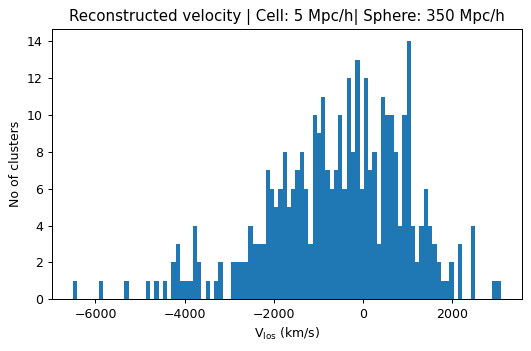

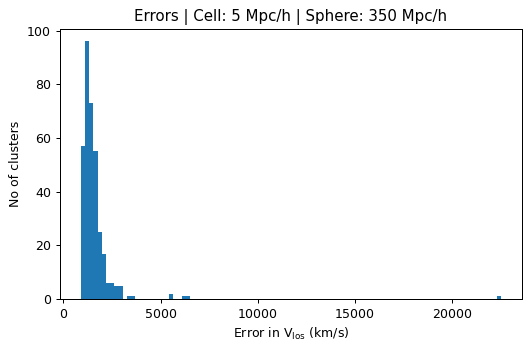

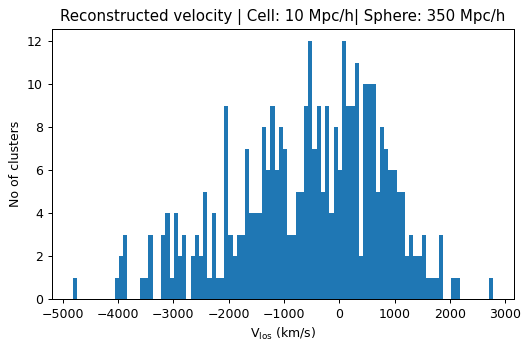

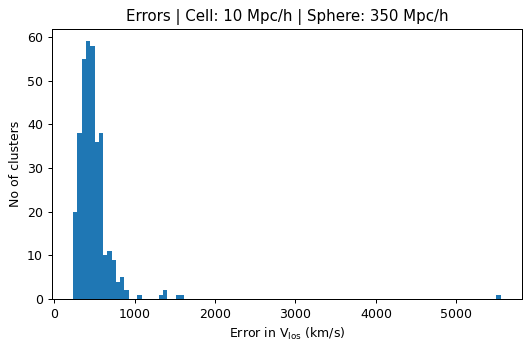

In [29]:
%%time
cores = 64
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

clus_mass_bins_results = pd.DataFrame(columns=['Cell Size',
                                'Cube Size', 'Clusters', 
                                'Slope - Vlos', 'Error - Slope - Vlos', 
                                'Intercept - Vlos', 'Scatter - Vlos'])


# clus_cube_sizes = [400000, 500000, 60000]
for clus_cube_size in [700000]:
    for cell_size in [5000, 10000]:                       #kpc/h, size of pixel or cell
#     for cell_size in [10000]: 
        
        t = time.time()                 
        print(cell_size, clus_cube_size)
        
        radius = int(clus_cube_size//2e3)        
        df_act_clus_available = df_clus_available_func(radius)
                
               
        vel_terms = vel_terms_calc(cell_size, clus_cube_size)        
        no_of_clus = len(df_act_clus_available)

        clus_param = list(zip(df_act_clus_available['x_comov[kpc/h]'], 
                                df_act_clus_available['y_comov[kpc/h]'], 
                                df_act_clus_available['z_comov[kpc/h]'], 
                                df_act_clus_available['redshift'], 
                                [cell_size] * no_of_clus,
                                [vel_terms]  * no_of_clus, 
                                [clus_cube_size] * no_of_clus
                               ))
        
        pool = multi.Pool(processes = cores)
        v_est = pool.starmap(clus_velocity_calc, clus_param)

        
        df_clusters_est_err = df_act_clus_available.copy()    

        df_clusters_est_err['vx_est[km/s]'] = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]'] = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]'] = [i[2] for i in v_est]

        df_clusters_est_err['vx_est_err[km/s]'] = [i[3] for i in v_est]
        df_clusters_est_err['vy_est_err[km/s]'] = [i[4] for i in v_est]
        df_clusters_est_err['vz_est_err[km/s]'] = [i[5] for i in v_est]
        
        df_clusters_est_err['r_mag[kpc/h]'] = np.sqrt(df_clusters_est_err['x_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['y_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['z_comov[kpc/h]']**2)
        
        df_clusters_est_err['v_los_est[km/s]'] = (((df_clusters_est_err['vx_est[km/s]'] * df_clusters_est_err['x_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vy_est[km/s]'] * df_clusters_est_err['y_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vz_est[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'])) /
                                                    df_clusters_est_err['r_mag[kpc/h]'])
        
        df_clusters_est_err['v_los_est_err[km/s]'] = \
            np.sqrt((df_clusters_est_err['vx_est_err[km/s]'] * df_clusters_est_err['x_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vy_est_err[km/s]'] * df_clusters_est_err['y_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vz_est_err[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2)

        
        plotting_func(df_clusters_est_err, cell_size, clus_cube_size)
        
        
        df_clusters_est_err.to_csv(f'Data/with_vels/z_gt_3_lt_6_{radius}_{cell_size}.csv')
        
# #         clear_output(wait=True)
        
                


        
#         clus_mass_bins_results = clus_mass_bins_results.append({'Cell Size': cell_size,
#                 'Cube Size': clus_cube_size,
#                 'Clusters': no_of_clus,
                                                                                                                                                                    
#                 'Slope - Vlos': round(param_los_scipy[0][0], 3),  
#                 'Error - Slope - Vlos': round(np.sqrt(param_los_scipy[1][0, 0]), 3), 
#                 'Intercept - Vlos': round(param_los_scipy[0][1], 3),
#                 'Scatter - Vlos': 'Not-calculated',
               
#                                                                                }, 
#                 ignore_index=True)
        
        
        print('Time taken:', time.time() - t)
        print('\n')
        

5000 200000
Time taken: 4.842221021652222


10000 200000
Time taken: 4.185854196548462


CPU times: user 2.94 s, sys: 3.73 s, total: 6.68 s
Wall time: 9.03 s


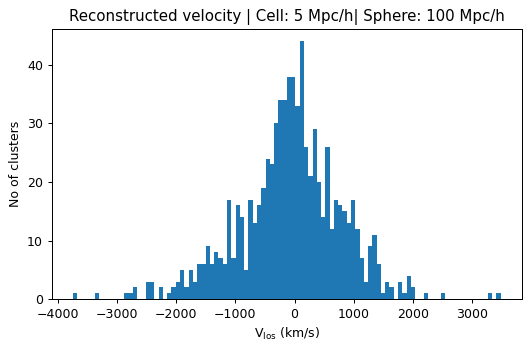

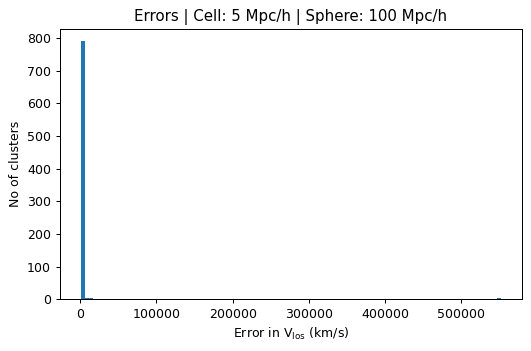

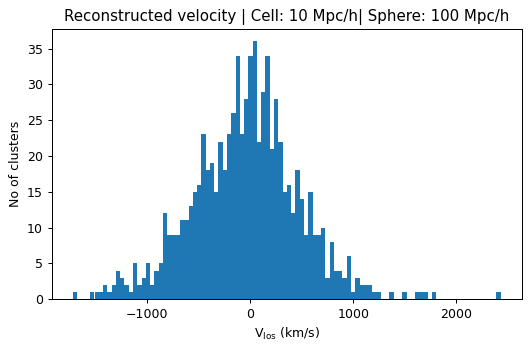

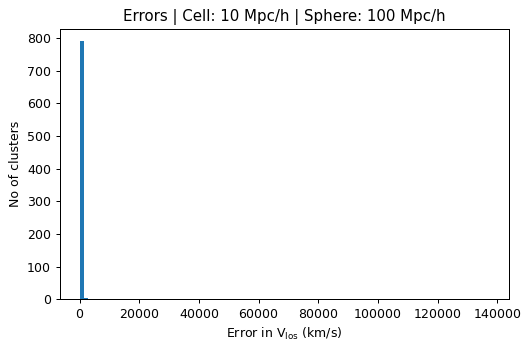

In [30]:
%%time
cores = 64
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

clus_mass_bins_results = pd.DataFrame(columns=['Cell Size',
                                'Cube Size', 'Clusters', 
                                'Slope - Vlos', 'Error - Slope - Vlos', 
                                'Intercept - Vlos', 'Scatter - Vlos'])


# clus_cube_sizes = [400000, 500000, 60000]
for clus_cube_size in [200000]:
    for cell_size in [5000, 10000]:                       #kpc/h, size of pixel or cell
#     for cell_size in [10000]: 
        
        t = time.time()                 
        print(cell_size, clus_cube_size)
        
        radius = int(clus_cube_size//2e3)        
        df_act_clus_available = df_clus_available_func(radius)
                
               
        vel_terms = vel_terms_calc(cell_size, clus_cube_size)        
        no_of_clus = len(df_act_clus_available)

        clus_param = list(zip(df_act_clus_available['x_comov[kpc/h]'], 
                                df_act_clus_available['y_comov[kpc/h]'], 
                                df_act_clus_available['z_comov[kpc/h]'], 
                                df_act_clus_available['redshift'], 
                                [cell_size] * no_of_clus,
                                [vel_terms]  * no_of_clus, 
                                [clus_cube_size] * no_of_clus
                               ))
        pool = multi.Pool(processes = cores)
        v_est = pool.starmap(clus_velocity_calc, clus_param)

        
        df_clusters_est_err = df_act_clus_available.copy()    

        df_clusters_est_err['vx_est[km/s]'] = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]'] = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]'] = [i[2] for i in v_est]

        df_clusters_est_err['vx_est_err[km/s]'] = [i[3] for i in v_est]
        df_clusters_est_err['vy_est_err[km/s]'] = [i[4] for i in v_est]
        df_clusters_est_err['vz_est_err[km/s]'] = [i[5] for i in v_est]
        
        df_clusters_est_err['r_mag[kpc/h]'] = np.sqrt(df_clusters_est_err['x_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['y_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['z_comov[kpc/h]']**2)
        
        df_clusters_est_err['v_los_est[km/s]'] = (((df_clusters_est_err['vx_est[km/s]'] * df_clusters_est_err['x_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vy_est[km/s]'] * df_clusters_est_err['y_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vz_est[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'])) /
                                                    df_clusters_est_err['r_mag[kpc/h]'])
        
        df_clusters_est_err['v_los_est_err[km/s]'] = \
            np.sqrt((df_clusters_est_err['vx_est_err[km/s]'] * df_clusters_est_err['x_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vy_est_err[km/s]'] * df_clusters_est_err['y_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vz_est_err[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2)

        
        plotting_func(df_clusters_est_err, cell_size, clus_cube_size)
        
        
        df_clusters_est_err.to_csv(f'Data/with_vels/z_gt_3_lt_6_{radius}_{cell_size}.csv')
        
# #         clear_output(wait=True)
        
                


        
#         clus_mass_bins_results = clus_mass_bins_results.append({'Cell Size': cell_size,
#                 'Cube Size': clus_cube_size,
#                 'Clusters': no_of_clus,
                                                                                                                                                                    
#                 'Slope - Vlos': round(param_los_scipy[0][0], 3),  
#                 'Error - Slope - Vlos': round(np.sqrt(param_los_scipy[1][0, 0]), 3), 
#                 'Intercept - Vlos': round(param_los_scipy[0][1], 3),
#                 'Scatter - Vlos': 'Not-calculated',
               
#                                                                                }, 
#                 ignore_index=True)
        
        
        print('Time taken:', time.time() - t)
        print('\n')
        

**1 Sep 2021**  
- With 100 Mpc, looks much better. Still, the maximum is not at zero but very close. Yes, it's a matter of sampling. So, calculate moments. We'll see they reduce with (increasing) the number of clusters. 

In [73]:
df_clusters_est_err_copy = df_clusters_est_err.copy()
df_clusters_est_err_copy.describe()

RADeg      decDeg    redshift       M500c  r_comov[Mpc/h]  \
count  561.000000  561.000000  561.000000  561.000000      561.000000   
mean   176.624574   12.310269    0.463317    2.463438     1227.806585   
std    103.265442    5.465183    0.083092    0.939377      194.288603   
min      0.113533   -2.238985    0.304100    1.185268      844.528737   
25%    124.738767    9.504385    0.401126    1.858159     1085.363599   
50%    188.600000   13.448737    0.465810    2.239340     1238.413854   
75%    232.442358   16.666769    0.539365    2.812541     1405.376496   
max    359.887357   20.429152    0.599900    8.222190     1537.309699   

       x_comov[Mpc/h]  y_comov[Mpc/h]  z_comov[Mpc/h]  x_comov[kpc/h]  \
count      561.000000      561.000000      561.000000    5.610000e+02   
mean      -174.712968      -96.474452      257.768141   -1.747130e+05   
std       1032.619421      600.847523      119.005478    1.032619e+06   
min      -1481.162794    -1353.883266      -55.897525   -1.481163e+06   
25%      -1053.119940     -569.322819      200.991647   -1.053120e+06   
50%       -683.977088      -94.704433      269.171839   -6.839771e+05   
75%       1033.097449      352.658393      337.687807    1.033097e+06   
max       1487.108914     1254.273219      512.761977    1.487109e+06   

       y_comov[kpc/h]  z_comov[kpc/h]  vx_est[km/s]  vy_est[km/s]  \
count    5.610000e+02      561.000000    561.000000    561.000000   
mean    -9.647445e+04   257768.140590     39.373585     -3.808278   
std      6.008475e+05   119005.477821    953.878405    926.940471   
min     -1.353883e+06   -55897.524538  -3066.339567  -3759.733988   
25%     -5.693228e+05   200991.647016   -483.222026   -455.281658   
50%     -9.470443e+04   269171.838568     20.357756     13.351324   
75%      3.526584e+05   337687.807057    699.774660    502.059638   
max      1.254273e+06   512761.976652   2503.951815   3094.609028   

       vz_est[km/s]  vx_est_err[km/s]  vy_est_err[km/s]  vz_est_err[km/s]  \
count    561.000000        561.000000        561.000000        561.000000   
mean     -82.240693        471.443233        471.497287        471.595866   
std      830.258399        494.625374        494.847545        494.769683   
min    -4981.438190        228.301719        224.115616        221.303176   
25%     -510.910620        367.344689        365.685614        366.641419   
50%      -92.808877        425.868827        429.304775        427.117294   
75%      362.666870        495.095979        496.609282        499.008083   
max     3503.671275      11602.813728      11603.152037      11603.488733   

       r_mag[kpc/h]  v_los_est[km/s]  v_los_est_err[km/s]  
count  5.610000e+02       561.000000           561.000000  
mean   1.227807e+06      -265.033530           471.750014  
std    1.942886e+05       926.627441           494.659957  
min    8.445287e+05     -3301.491490           228.566078  
25%    1.085364e+06      -843.468385           366.474671  
50%    1.238414e+06      -258.285847           427.390303  
75%    1.405376e+06       357.895187           496.046818  
max    1.537310e+06      3331.237308         11602.987187

In [74]:
from uncertainties import ufloat
from uncertainties import unumpy

In [83]:

df_clusters_est_err['vx_est_with_err[km/s]'] = unumpy.uarray(df_clusters_est_err['vx_est[km/s]'], 
                                                             df_clusters_est_err['vx_est_err[km/s]'])

df_clusters_est_err['vy_est_with_err[km/s]'] = unumpy.uarray(df_clusters_est_err['vy_est[km/s]'], 
                                                             df_clusters_est_err['vy_est_err[km/s]'])

df_clusters_est_err['vz_est_with_err[km/s]'] = unumpy.uarray(df_clusters_est_err['vz_est[km/s]'], 
                                                             df_clusters_est_err['vz_est_err[km/s]'])

df_clusters_est_err['v_los_est_err[km/s]'] = \
        unumpy.std_devs(((df_clusters_est_err['vx_est_with_err[km/s]'] * df_clusters_est_err['x_comov[kpc/h]']) +
                         (df_clusters_est_err['vy_est_with_err[km/s]'] * df_clusters_est_err['y_comov[kpc/h]']) +
                         (df_clusters_est_err['vz_est_with_err[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'])) /
                          df_clusters_est_err['r_mag[kpc/h]'])

# df_clusters_est_err['v_los_est_err[km/s]'] = \
#             np.sqrt((df_clusters_est_err['vx_est_err[km/s]'] * df_clusters_est_err['x_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
#                     (df_clusters_est_err['vy_est_err[km/s]'] * df_clusters_est_err['y_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
#                     (df_clusters_est_err['vz_est_err[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2)

df_clusters_est_err.describe()

RADeg      decDeg    redshift       M500c  r_comov[Mpc/h]  \
count  561.000000  561.000000  561.000000  561.000000      561.000000   
mean   176.624574   12.310269    0.463317    2.463438     1227.806585   
std    103.265442    5.465183    0.083092    0.939377      194.288603   
min      0.113533   -2.238985    0.304100    1.185268      844.528737   
25%    124.738767    9.504385    0.401126    1.858159     1085.363599   
50%    188.600000   13.448737    0.465810    2.239340     1238.413854   
75%    232.442358   16.666769    0.539365    2.812541     1405.376496   
max    359.887357   20.429152    0.599900    8.222190     1537.309699   

       x_comov[Mpc/h]  y_comov[Mpc/h]  z_comov[Mpc/h]  x_comov[kpc/h]  \
count      561.000000      561.000000      561.000000    5.610000e+02   
mean      -174.712968      -96.474452      257.768141   -1.747130e+05   
std       1032.619421      600.847523      119.005478    1.032619e+06   
min      -1481.162794    -1353.883266      -55.897525   -1.481163e+06   
25%      -1053.119940     -569.322819      200.991647   -1.053120e+06   
50%       -683.977088      -94.704433      269.171839   -6.839771e+05   
75%       1033.097449      352.658393      337.687807    1.033097e+06   
max       1487.108914     1254.273219      512.761977    1.487109e+06   

       y_comov[kpc/h]  z_comov[kpc/h]  vx_est[km/s]  vy_est[km/s]  \
count    5.610000e+02      561.000000    561.000000    561.000000   
mean    -9.647445e+04   257768.140590     39.373585     -3.808278   
std      6.008475e+05   119005.477821    953.878405    926.940471   
min     -1.353883e+06   -55897.524538  -3066.339567  -3759.733988   
25%     -5.693228e+05   200991.647016   -483.222026   -455.281658   
50%     -9.470443e+04   269171.838568     20.357756     13.351324   
75%      3.526584e+05   337687.807057    699.774660    502.059638   
max      1.254273e+06   512761.976652   2503.951815   3094.609028   

       vz_est[km/s]  vx_est_err[km/s]  vy_est_err[km/s]  vz_est_err[km/s]  \
count    561.000000        561.000000        561.000000        561.000000   
mean     -82.240693        471.443233        471.497287        471.595866   
std      830.258399        494.625374        494.847545        494.769683   
min    -4981.438190        228.301719        224.115616        221.303176   
25%     -510.910620        367.344689        365.685614        366.641419   
50%      -92.808877        425.868827        429.304775        427.117294   
75%      362.666870        495.095979        496.609282        499.008083   
max     3503.671275      11602.813728      11603.152037      11603.488733   

       r_mag[kpc/h]  v_los_est[km/s]  v_los_est_err[km/s]  
count  5.610000e+02            561.0           561.000000  
mean   1.227807e+06              0.0           471.750014  
std    1.942886e+05              0.0           494.659957  
min    8.445287e+05              0.0           228.566078  
25%    1.085364e+06              0.0           366.474671  
50%    1.238414e+06              0.0           427.390303  
75%    1.405376e+06              0.0           496.046818  
max    1.537310e+06              0.0         11602.987187

5000 500000
Time taken: 23.91452169418335


10000 500000
Time taken: 5.753413438796997


CPU times: user 6.66 s, sys: 16.2 s, total: 22.8 s
Wall time: 29.7 s


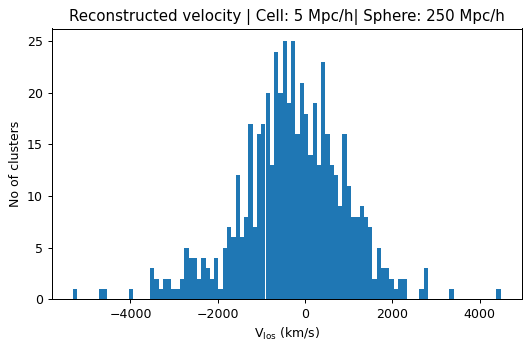

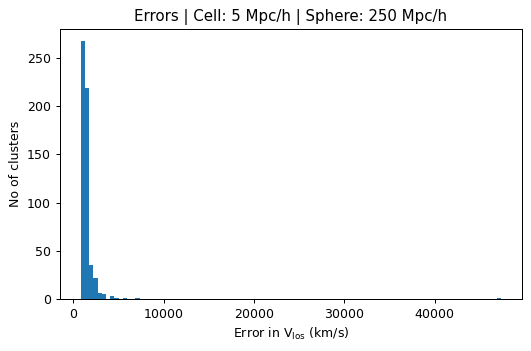

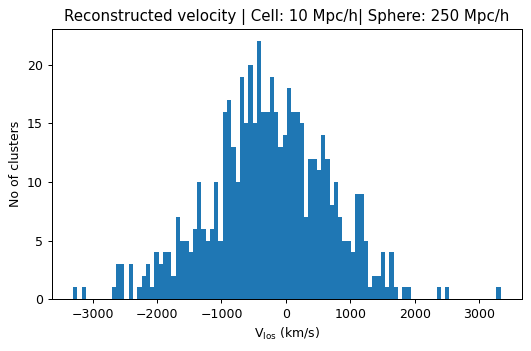

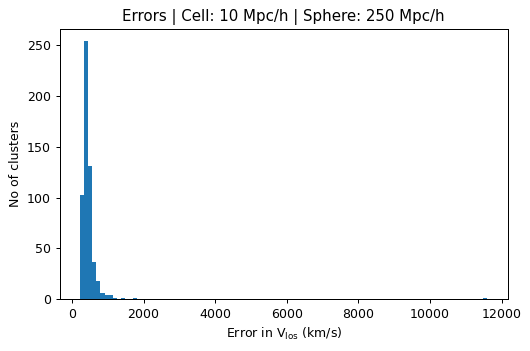

In [31]:
%%time
cores = 64
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

clus_mass_bins_results = pd.DataFrame(columns=['Cell Size',
                                'Cube Size', 'Clusters', 
                                'Slope - Vlos', 'Error - Slope - Vlos', 
                                'Intercept - Vlos', 'Scatter - Vlos'])


# clus_cube_sizes = [400000, 500000, 60000]
for clus_cube_size in [500000]:
    for cell_size in [5000, 10000]:                       #kpc/h, size of pixel or cell
#     for cell_size in [10000]: 
        
        t = time.time()                 
        print(cell_size, clus_cube_size)
        
        radius = int(clus_cube_size//2e3)        
        df_act_clus_available = df_clus_available_func(radius)
                
               
        vel_terms = vel_terms_calc(cell_size, clus_cube_size)        
        no_of_clus = len(df_act_clus_available)

        clus_param = list(zip(df_act_clus_available['x_comov[kpc/h]'], 
                                df_act_clus_available['y_comov[kpc/h]'], 
                                df_act_clus_available['z_comov[kpc/h]'], 
                                df_act_clus_available['redshift'], 
                                [cell_size] * no_of_clus,
                                [vel_terms]  * no_of_clus, 
                                [clus_cube_size] * no_of_clus
                               ))
        pool = multi.Pool(processes = cores)
        v_est = pool.starmap(clus_velocity_calc, clus_param)

        
        df_clusters_est_err = df_act_clus_available.copy()    

        df_clusters_est_err['vx_est[km/s]'] = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]'] = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]'] = [i[2] for i in v_est]

        df_clusters_est_err['vx_est_err[km/s]'] = [i[3] for i in v_est]
        df_clusters_est_err['vy_est_err[km/s]'] = [i[4] for i in v_est]
        df_clusters_est_err['vz_est_err[km/s]'] = [i[5] for i in v_est]
        
        df_clusters_est_err['r_mag[kpc/h]'] = np.sqrt(df_clusters_est_err['x_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['y_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['z_comov[kpc/h]']**2)
        
        df_clusters_est_err['v_los_est[km/s]'] = (((df_clusters_est_err['vx_est[km/s]'] * df_clusters_est_err['x_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vy_est[km/s]'] * df_clusters_est_err['y_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vz_est[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'])) /
                                                    df_clusters_est_err['r_mag[kpc/h]'])
        
        
        df_clusters_est_err['v_los_est_err[km/s]'] = \
            np.sqrt((df_clusters_est_err['vx_est_err[km/s]'] * df_clusters_est_err['x_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vy_est_err[km/s]'] * df_clusters_est_err['y_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vz_est_err[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2)
    
        
        plotting_func(df_clusters_est_err, cell_size, clus_cube_size)
        
        
        df_clusters_est_err.to_csv(f'Data/with_vels/z_gt_3_lt_6_{radius}_{cell_size}.csv')
        

        
#         clus_mass_bins_results = clus_mass_bins_results.append({'Cell Size': cell_size,
#                 'Cube Size': clus_cube_size,
#                 'Clusters': no_of_clus,
                                                                                                                                                                    
#                 'Slope - Vlos': round(param_los_scipy[0][0], 3),  
#                 'Error - Slope - Vlos': round(np.sqrt(param_los_scipy[1][0, 0]), 3), 
#                 'Intercept - Vlos': round(param_los_scipy[0][1], 3),
#                 'Scatter - Vlos': 'Not-calculated',
               
#                                                                                }, 
#                 ignore_index=True)
        
        
        print('Time taken:', time.time() - t)
        print('\n')
        

**27 Aug 2021**  
A: Delta has an evolution. It could be less on one side of the box and more on the other. Not accouting for it can create a velocity dipole. Should be discussed with Emilio. Good to mention we can get a bias from this mistake. Though, people must have been taking care of it even if they don't mention it.  
**Task** There's no redshift evolution in 240 Mpc radius or diameter region. Worth trying to use only surrounding sphere to compute delta. Rerun one Magneticum result.  
**Task** Scatterplot to see how delta mean change (how it fluctuates) for the cluster catalog from the Magneticum.  
**Task** Check redshift intervel for Magneticum box. Must be .3 or .4. Have to plug in the distance formulat to get the redshift.  
**Task** Also calculate Poisson errors to see if it is matching the ones from Magneticum.  
**Task** Compare histograms of velocities from both Magneticum and SDSS for 5 Mpc, 10 Mpc and 20 Mpc.

**1 Sep 2021**  
A:
- The errors are smaller with 10 Mpc (go to basically 5000) than 5 Mpc (goes to 15000). This is because we have more galaxies in each cell for 10 Mpc.  

Getting true velocities

- To get true velocity, a thought was to do brute force samping from a true distribution to reconstructed distribution.
- We know how to go forward: we have a line with its own error: intercept error and slope error. So for each draw (of x which is v_true), we can always draw some random values of intercept and slope for each x axis value and on that add quadrature the scatter because scatter is also a Gaussion. And that will give you a y value. We can go from x to y. But how to go backwards from y to x?
- If this is a straight line, one can make the equation work both ways. But regression with a scatter is not interchangeable. You cannot flip because you use the error model along the Y, and scatter model in the y direction, not the X direction. Here, you fit the regression for the y values with respect to x, not the other way. Our regression basically only tells us how to go to Y value from x but not the other way around.
- If we want to map 10,000 distributions in X to see which one finally comes closest to Y that is not a very meaningful approach. It's not a well-defined. You never know if that is the solution right. You cannot just trial and error.. unless we have a theoretical model and we can define some chi square probability and do some MCMC kind of stuff. But we don't have any theoretical model for x velocities. 
- One easy way is to fit this regression in two parts. One is the bias part that is the deviation of the mean line from one is to one, that's the green line. Forget the errors for a moment. You get one unique definite X distribution whose errors are the same as the y distribution. 
- This error that we get is only from the error of galaxy count. There is an additional error because we don't have an infinite sample of galaxies cluster.. we have only a finite sample. So the determination of this green line also had an error and this error is encoded into the correlation coefficient. How much points scatter up and down from this. So (second part is) the error that is defined by the correlation coefficient, the scatter of the points. Then you can reverse map the Y distribution.
- ACT team assume there is a random component that does not match and reduce their Signal to Noise, obtained after stacking, by multiplying it with the correlation co-efficient. This just means increasing the noise or error. This method does not take into account any bias.
- Ideally, we wanted to do something more direct, use the full regression with its error to remap the reconstructed velocities to true velocity. If we figure out this method, it'd be great to compare it with the above easy method.
- We found two biases: 1. using a larger cell, 2. having mass bias, different mass bins have different slopes. So we must take into account these two biases. From 800 cluster, maybe we can make three mass bins. Then we have to apply three different regressions for the three mass bins.

Local density
- Mention in the write-ups we are using local field to calculate mean density.

**15 Sep 2021**  
B:
- Peculiar velocity and error magnitudes are acceptable numbers for these redshifts.
- Vel bias of clusters moving towards us could be due to cosmic variance, small volume, sampling limitation, selectio bias or more galaxy density at lower redshift than higher. Probably, cosmic variance plus this large statistical variance at each bin point. Or edge effects (cluster close to boundary).
- Direction bias understandable for 5 Mpc but not for 10 Mpc
- 10 Mpc (guess) vel hist better. Must be having Kurtosis close to zero. Vel dist not expected to be Gaussian.
- We can try 350 Mpc spheres. If we still see it, we can argue something is wrong with data. If it disappears, it means we need to correct for it when using smaller volumes.
- **Task** Let's quantify this bias. Compute the second order moment of the distribution. First moment is also biased because of our choice of cell sizes, we never get perfectly one is to one line.
- **Task** Check maximum (mode) of bins.
- **Task** Identify issue with high error clusters.

Text(0, 0.5, 'Error in V$_{\\mathrm{los}}$')

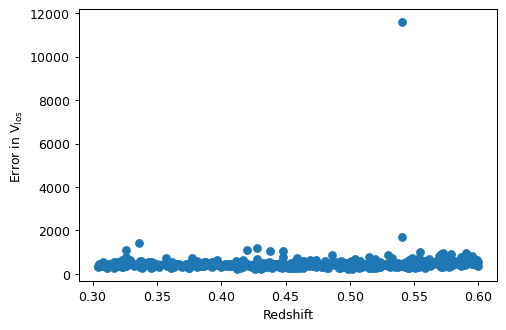

In [67]:
plt.figure(dpi = dpi)
plt.scatter(df_clusters_est_err_sorted['redshift'], df_clusters_est_err_sorted['v_los_est_err[km/s]'])
# plt.yscale('log')
plt.xlabel('Redshift')
plt.ylabel('Error in V$_{\mathrm{los}}$')

Text(0, 0.5, 'Error in V$_{\\mathrm{los}}$')

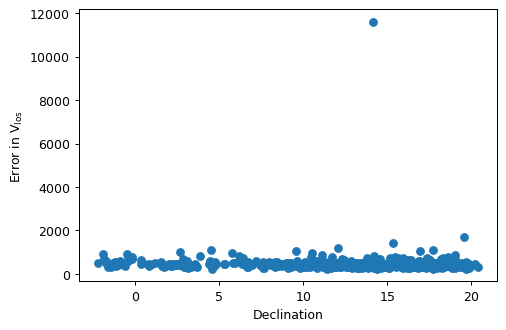

In [86]:
plt.figure(dpi = dpi)
plt.scatter(df_clusters_est_err_sorted['decDeg'], df_clusters_est_err_sorted['v_los_est_err[km/s]'])
# plt.yscale('log')
plt.xlabel('Declination')
plt.ylabel('Error in V$_{\mathrm{los}}$')

Text(0, 0.5, 'Error in V$_{\\mathrm{los}}$')

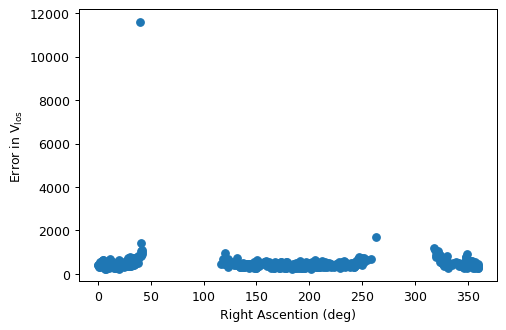

In [106]:
plt.figure(dpi = dpi)
plt.scatter(df_clusters_est_err_sorted['RADeg'], df_clusters_est_err_sorted['v_los_est_err[km/s]'])
# plt.yscale('log')
plt.xlabel('Right Ascention (deg)')
plt.ylabel('Error in V$_{\mathrm{los}}$')

In [60]:
df_clusters_est_err_sorted = df_clusters_est_err.sort_values(by='v_los_est_err[km/s]', ascending=False)
df_clusters_est_err_sorted

RADeg     decDeg  redshift     M500c  r_comov[Mpc/h]  \
119   40.282087  14.183075  0.540200  3.225565     1407.229675   
476  263.080715  19.554485  0.540200  3.230010     1407.229675   
122   41.116854  15.358533  0.336200  2.689441      925.722375   
477  317.954075  12.049949  0.428000  3.172701     1149.670067   
124   41.622292   4.494482  0.420384  2.213281     1131.549816   
..          ...        ...       ...       ...             ...   
322  201.308283  19.683333  0.498200  1.986501     1312.851341   
261  183.995810  17.754171  0.501519  1.711979     1320.396287   
17     6.920855   4.537524  0.425991  1.956637     1144.899359   
62    20.100000  11.429218  0.412263  2.324169     1112.137393   
21     7.795835  14.408333  0.430984  2.372676     1156.748203   

     x_comov[Mpc/h]  y_comov[Mpc/h]  z_comov[Mpc/h]  inside_clus  \
119     1040.810302      882.112046      344.800830         True   
476     -159.752451    -1316.407844      471.004141         True   
122      672.505044      587.011989      245.185249         True   
477      834.942826     -752.998598      240.010107         True   
124      843.277257      749.283510       88.671737         True   
..              ...             ...             ...          ...   
322    -1151.635444     -449.195713      442.196402         True   
261    -1254.453749      -87.627764      402.633233         True   
17      1132.994833      137.525901       90.575254         True   
62      1023.691607      374.617930      220.378040         True   
21      1110.010233      151.970288      287.834534         True   

                              gals_beyond_250Mpc  ...  z_comov[kpc/h]  \
119        [3425, 60127, 37, 92102, 1418, 16164]  ...   344800.830081   
476              [88, 24707, 72095, 19, 5406, 1]  ...   471004.140554   
122        [35128, 82359, 79, 62773, 1448, 6883]  ...   245185.249147   
477        [19336, 78861, 76583, 18, 1563, 2044]  ...   240010.106972   
124       [22561, 52935, 203, 72922, 3403, 1391]  ...    88671.736680   
..                                           ...  ...             ...   
322    [97261, 7097, 87378, 23165, 24409, 19005]  ...   442196.402275   
261   [145347, 5179, 51110, 41065, 26219, 13089]  ...   402633.233258   
17    [15563, 158751, 36612, 45217, 30774, 1850]  ...    90575.254055   
62    [21043, 122611, 10151, 63348, 18895, 8455]  ...   220378.040126   
21   [14421, 172104, 24378, 45493, 17009, 14020]  ...   287834.533626   

     vx_est[km/s]  vy_est[km/s]  vz_est[km/s]  vx_est_err[km/s]  \
119    726.226639  -1252.583758  -1643.022281      11602.813728   
476  -2347.706369   1815.507189   2090.003808       1708.676131   
122   1161.864248  -1695.897762  -1099.509698       1405.669438   
477   2009.872012   1237.876587  -3085.190290       1210.319392   
124   1564.498987  -2753.476625  -1472.625058       1122.628185   
..            ...           ...           ...               ...   
322   -131.220796    -68.498513    370.046138        238.253705   
261    626.725126    291.183358   -177.504252        236.208269   
17     -88.853537    369.136427     93.078308        231.102394   
62     193.180881    113.940935     76.264726        228.301719   
21     236.840070    -82.710658   -363.209745        228.508221   

     vy_est_err[km/s]  vz_est_err[km/s]  r_mag[kpc/h]  v_los_est[km/s]  \
119      11603.152037      11603.488733  1.407230e+06      -650.619097   
476       1708.309798       1708.644211  1.407230e+06      -732.286726   
122       1405.997261       1406.076318  9.257224e+05      -522.550090   
477       1209.679324       1211.441425  1.149670e+06         4.811843   
124       1106.323621       1099.273996  1.131550e+06      -772.752930   
..                ...               ...           ...              ...   
322        245.723045        242.396241  1.312851e+06       263.183513   
261        224.115616        221.303176  1.320396e+06      -668.876875   
17         231.033980        231.417651  1.144899e+0

In [91]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [92]:
temp = SkyCoord(ra=10.68458*u.degree, dec=41.26917*u.degree, frame='icrs')
temp.galactic

<SkyCoord (Galactic): (l, b) in deg
    (121.17424181, -21.57288557)>

In [93]:
temp = SkyCoord(ra=10.68458*u.degree, dec=41.26917*u.degree)
temp.galactic

<SkyCoord (Galactic): (l, b) in deg
    (121.17424181, -21.57288557)>

In [95]:
temp = SkyCoord(ra=10.68458*u.degree, dec=41.26917*u.degree)
temp.galactic.l.deg

121.17424181126054

In [98]:
gal_coord = SkyCoord(ra=df_clusters_est_err_sorted['RADeg']*u.degree, 
                     dec=df_clusters_est_err_sorted['decDeg']*u.degree)
df_clusters_est_err_sorted['gal_long'] = gal_coord.galactic.l.deg
df_clusters_est_err_sorted['gal_lat'] = gal_coord.galactic.b.deg

Text(0, 0.5, 'Galactic latitude (deg)')

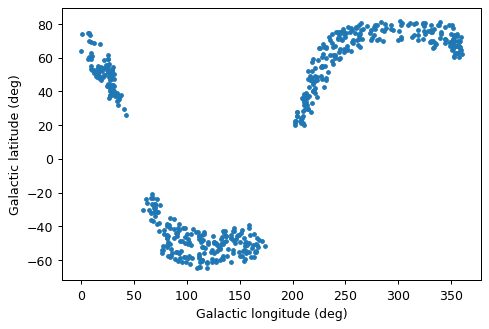

In [102]:
plt.figure(dpi = dpi)
plt.scatter(df_clusters_est_err_sorted['gal_long'], df_clusters_est_err_sorted['gal_lat'], 
           s = 8)
# plt.yscale('log')
plt.xlabel('Galactic longitude (deg)')
plt.ylabel('Galactic latitude (deg)')

Text(0, 0.5, 'Error in V$_{\\mathrm{los}}$')

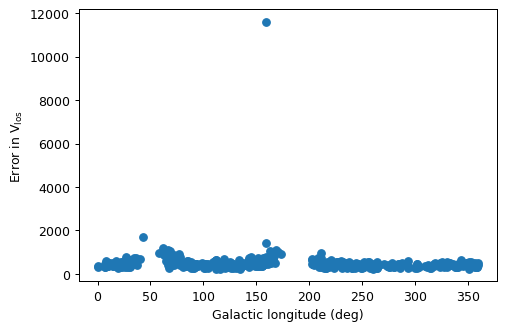

In [104]:
plt.figure(dpi = dpi)
plt.scatter(df_clusters_est_err_sorted['gal_long'], df_clusters_est_err_sorted['v_los_est_err[km/s]'])
# plt.yscale('log')
plt.xlabel('Galactic longitude (deg)')
plt.ylabel('Error in V$_{\mathrm{los}}$')

Text(0, 0.5, 'Error in V$_{\\mathrm{los}}$')

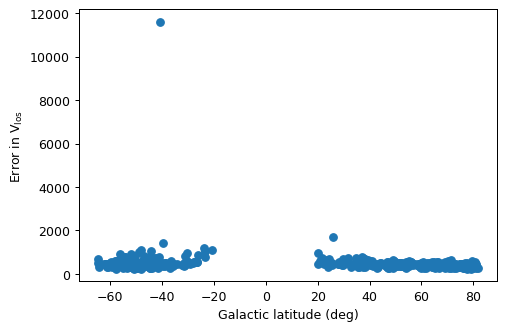

In [105]:
plt.figure(dpi = dpi)
plt.scatter(df_clusters_est_err_sorted['gal_lat'], df_clusters_est_err_sorted['v_los_est_err[km/s]'])
# plt.yscale('log')
plt.xlabel('Galactic latitude (deg)')
plt.ylabel('Error in V$_{\mathrm{los}}$')

In [61]:
min_gals_beyond_cube = []
for i in df_clusters_est_err_sorted['gals_beyond_250Mpc']:
    nums_int_list = []
    nums = i.split(',')
    for num in nums:
        num = num.lstrip('[').rstrip(']')
        nums_int_list.append(int(num))
    min_gals_beyond_cube.append(min(nums_int_list))
    
df_clusters_est_err_sorted['min_gals_beyond_cube'] = min_gals_beyond_cube
df_clusters_est_err_sorted['min_gals_beyond_cube']

119       37
476        1
122       79
477       18
124      203
       ...  
322     7097
261     5179
17      1850
62      8455
21     14020
Name: min_gals_beyond_cube, Length: 561, dtype: int64

Text(0, 0.5, 'Error in V$_{\\mathrm{los}}$')

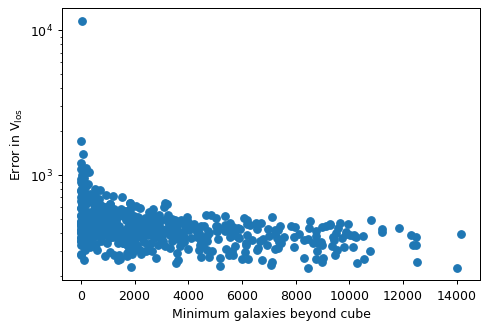

In [62]:
plt.figure(dpi = dpi)
plt.scatter(df_clusters_est_err_sorted['min_gals_beyond_cube'], df_clusters_est_err_sorted['v_los_est_err[km/s]'])
plt.yscale('log')
plt.xlabel('Minimum galaxies beyond cube')
plt.ylabel('Error in V$_{\mathrm{los}}$')

**17 Nov 2021**  
A: 
- Throw away the clusters with high error (>10^3 km/s). We can say that they happen to be in a void (have to prove it), so their velocity reconstruction is not so accurate. 
- Another criteria can be to throw away clusters above 5 percentile. But have to say the error is not due to our surve volume coming close to the boundary we define; this is really within in the bounday. Visually inspect (in 3D) the high error cluster to say it's indeed an underdensity or look for a void catalog.
- It can happen that the void is near the edge like swiss cheese. 
- Let's not waste too much time on them. We know we have throw them away.

B:
- The high error clusters could be in low density region within the SDSS volumne and not on the edge.

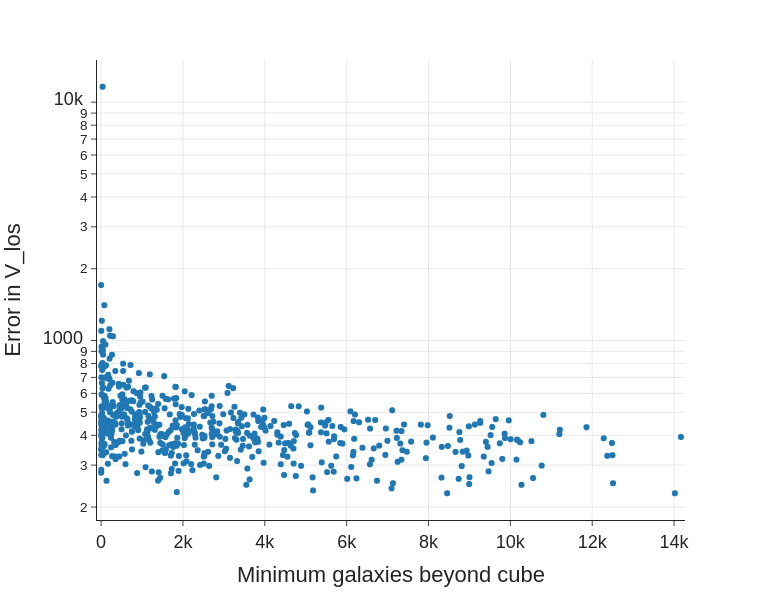

In [65]:
fig = px.scatter(x=df_clusters_est_err_sorted['min_gals_beyond_cube'], 
                 y=df_clusters_est_err_sorted['v_los_est_err[km/s]'],
                 labels={ "x": "Minimum galaxies beyond cube","y": "Error in V_los"},
                 log_y=True,
                 width=800,                  
                 height=600,
                 template="simple_white",   # 'ggplot2', 'seaborn', 'simple_white', 'plotly',
                                            # 'plotly_white', 'plotly_dark', 'presentation',
                                            # 'xgridoff', 'ygridoff', 'gridon', 'none'
                 range_x=[0-100, df_clusters_est_err_sorted['min_gals_beyond_cube'].max() + 100]
                 
                )
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.update_layout(font=dict(size=18))
    
fig.show()

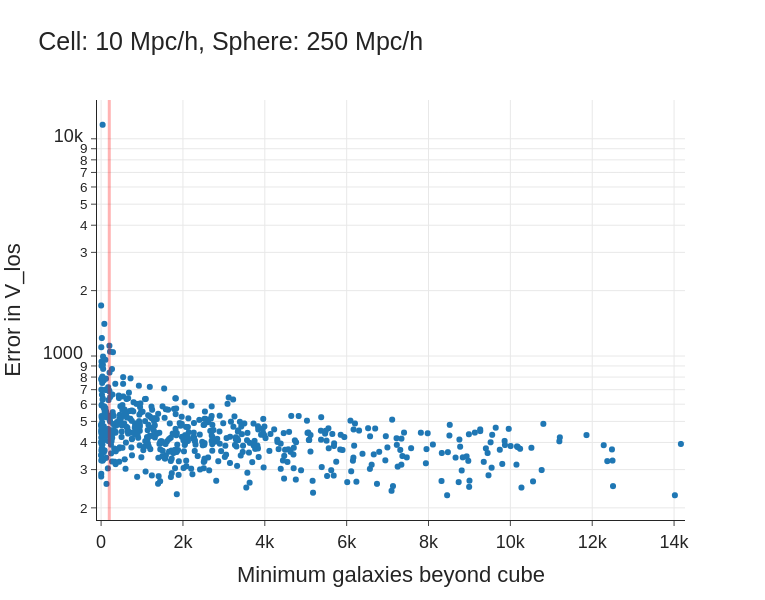

In [68]:
fig = px.scatter(x=df_clusters_est_err_sorted['min_gals_beyond_cube'], 
                 y=df_clusters_est_err_sorted['v_los_est_err[km/s]'],
                 labels={ "x": "Minimum galaxies beyond cube","y": "Error in V_los"},
                 log_y=True,
                 width=800,                  
                 height=600,
                 template="simple_white",   # 'ggplot2', 'seaborn', 'simple_white', 'plotly',
                                            # 'plotly_white', 'plotly_dark', 'presentation',
                                            # 'xgridoff', 'ygridoff', 'gridon', 'none'
                 range_x=[0-100, df_clusters_est_err_sorted['min_gals_beyond_cube'].max() + 100],
                 title='Cell: 10 Mpc/h, Sphere: 250 Mpc/h', 
                 
                )
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.update_layout(font=dict(size=18))
fig.add_vline(x=200, line_width=3, line_color = 'red')
# fig.title('Cell = 10000 Mpc/h')
    
fig.show()

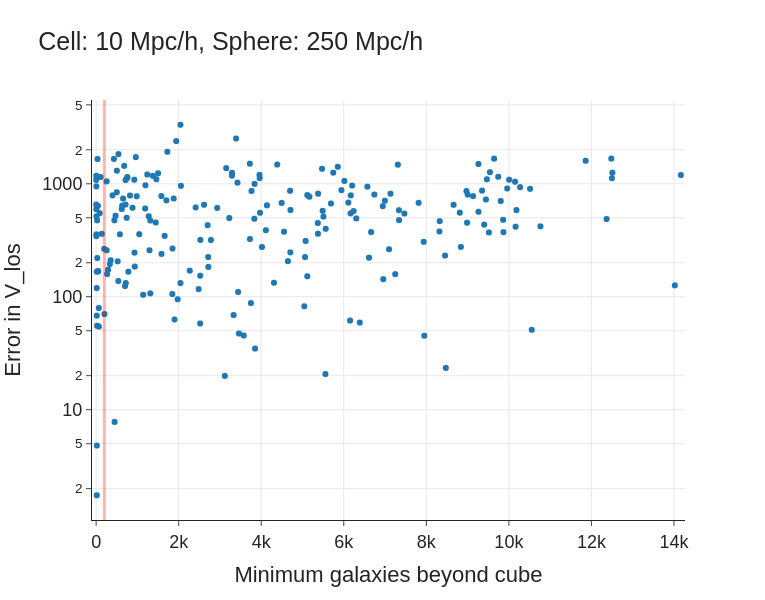

In [69]:
fig = px.scatter(x=df_clusters_est_err_sorted['min_gals_beyond_cube'], 
                 y=df_clusters_est_err_sorted['v_los_est[km/s]'],
                 labels={ "x": "Minimum galaxies beyond cube","y": "Error in V_los"},
                 log_y=True,
                 width=800,                  
                 height=600,
                 template="simple_white",   # 'ggplot2', 'seaborn', 'simple_white', 'plotly',
                                            # 'plotly_white', 'plotly_dark', 'presentation',
                                            # 'xgridoff', 'ygridoff', 'gridon', 'none'
                 range_x=[0-100, df_clusters_est_err_sorted['min_gals_beyond_cube'].max() + 100],
                 title='Cell: 10 Mpc/h, Sphere: 250 Mpc/h', 
                 
                )
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.update_layout(font=dict(size=18))
fig.add_vline(x=200, line_width=3, line_color = 'red')
# fig.title('Cell = 10000 Mpc/h')
    
fig.show()

In [32]:
skew_kurtosis = pd.DataFrame()


df_clus_100_5000 = pd.read_csv('Data/with_vels/z_gt_3_lt_6_100_5000.csv')
skew_kurtosis = skew_kurtosis.append({'Sphere': 100, 
                                      'Skewness' : df_clus_100_5000['v_los_est[km/s]'].skew(),
                                      'Kurtosis' : df_clus_100_5000['v_los_est[km/s]'].kurtosis()}, 
                                     ignore_index=True)

df_clus_250_5000 = pd.read_csv('Data/with_vels/z_gt_3_lt_6_250_5000.csv')
skew_kurtosis = skew_kurtosis.append({'Sphere': 250, 
                                      'Skewness' : df_clus_250_5000['v_los_est[km/s]'].skew(),
                                      'Kurtosis' : df_clus_250_5000['v_los_est[km/s]'].kurtosis()}, 
                                     ignore_index=True)

df_clus_350_5000 = pd.read_csv('Data/with_vels/z_gt_3_lt_6_350_5000.csv')
skew_kurtosis = skew_kurtosis.append({'Sphere': 350, 
                                      'Skewness' : df_clus_350_5000['v_los_est[km/s]'].skew(),
                                      'Kurtosis' : df_clus_350_5000['v_los_est[km/s]'].kurtosis()}, 
                                     ignore_index=True)

skew_kurtosis

Sphere  Skewness  Kurtosis
0   100.0 -0.278147  1.250154
1   250.0 -0.361523  1.276184
2   350.0 -0.642169  0.685143

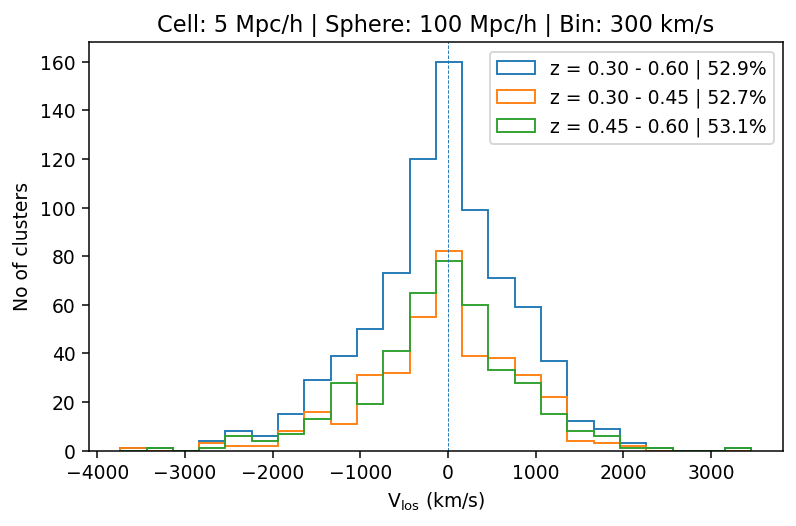

In [127]:
x_min = (df_clus_100_5000['v_los_est[km/s]'].min())

x_max = (df_clus_100_5000['v_los_est[km/s]'].max())

bin_size = 300
bins = np.arange(x_min, x_max, bin_size)

plt.figure(dpi = dpi*1.5)

neg_percent = (len(df_clus_100_5000[df_clus_100_5000['v_los_est[km/s]'] < 0]) / 
               len(df_clus_100_5000['v_los_est[km/s]'])) * 100
plt.hist(df_clus_100_5000['v_los_est[km/s]'], bins = bins,
         label = 'z = 0.30 - 0.60 | ' + str(round(neg_percent, 1)) + '%', histtype = 'step')

neg_percent = (len(df_clus_100_5000[(df_clus_100_5000['redshift'] < 0.45) &
                                    (df_clus_100_5000['v_los_est[km/s]'] < 0)]) / 
               len(df_clus_100_5000[df_clus_100_5000['redshift'] < 0.45]['v_los_est[km/s]'])) * 100
plt.hist(df_clus_100_5000[df_clus_100_5000['redshift'] < 0.45]['v_los_est[km/s]'], bins = bins,
         label = 'z = 0.30 - 0.45 | ' + str(round(neg_percent, 1)) + '%', histtype = 'step')

neg_percent = (len(df_clus_100_5000[(df_clus_100_5000['redshift'] > 0.45) &
                                    (df_clus_100_5000['v_los_est[km/s]'] < 0)]) / 
               len(df_clus_100_5000[df_clus_100_5000['redshift'] > 0.45]['v_los_est[km/s]'])) * 100
plt.hist(df_clus_100_5000[df_clus_100_5000['redshift'] > 0.45]['v_los_est[km/s]'], bins = bins,
         label = 'z = 0.45 - 0.60 | ' + str(round(neg_percent, 1)) + '%', histtype = 'step')

plt.legend()

plt.xlabel('V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('No of clusters')

plt.axvline(x = 0, ls = 'dashed', lw = 0.5)

plt.title(f'Cell: 5 Mpc/h | Sphere: 100 Mpc/h | Bin: {bin_size} km/s');

plt.tight_layout()
# plt.savefig('Plots/Practice_Talk/real_vels_5Mpc.pdf')cv

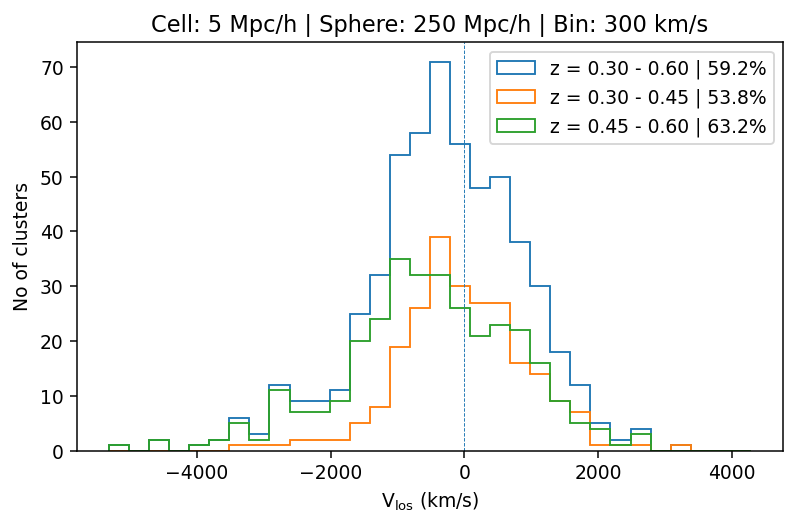

In [128]:
x_min = (df_clus_250_5000['v_los_est[km/s]'].min())

x_max = (df_clus_250_5000['v_los_est[km/s]'].max())

bin_size = 300
bins = np.arange(x_min, x_max, bin_size)

plt.figure(dpi = dpi*1.5)

neg_percent = (len(df_clus_250_5000[df_clus_250_5000['v_los_est[km/s]'] < 0]) / 
               len(df_clus_250_5000['v_los_est[km/s]'])) * 100
plt.hist(df_clus_250_5000['v_los_est[km/s]'], bins = bins,
         label = 'z = 0.30 - 0.60 | ' + str(round(neg_percent, 1)) + '%', histtype = 'step')

neg_percent = (len(df_clus_250_5000[(df_clus_250_5000['redshift'] < 0.45) &
                                    (df_clus_250_5000['v_los_est[km/s]'] < 0)]) / 
               len(df_clus_250_5000[df_clus_250_5000['redshift'] < 0.45]['v_los_est[km/s]'])) * 100
plt.hist(df_clus_250_5000[df_clus_250_5000['redshift'] < 0.45]['v_los_est[km/s]'], bins = bins,
         label = 'z = 0.30 - 0.45 | ' + str(round(neg_percent, 1)) + '%', histtype = 'step')

neg_percent = (len(df_clus_250_5000[(df_clus_250_5000['redshift'] > 0.45) &
                                    (df_clus_250_5000['v_los_est[km/s]'] < 0)]) / 
               len(df_clus_250_5000[df_clus_250_5000['redshift'] > 0.45]['v_los_est[km/s]'])) * 100
plt.hist(df_clus_250_5000[df_clus_250_5000['redshift'] > 0.45]['v_los_est[km/s]'], bins = bins,
         label = 'z = 0.45 - 0.60 | ' + str(round(neg_percent, 1)) + '%', histtype = 'step')

plt.legend()

plt.xlabel('V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('No of clusters')

plt.axvline(x = 0, ls = 'dashed', lw = 0.5)

plt.title(f'Cell: 5 Mpc/h | Sphere: 250 Mpc/h | Bin: {bin_size} km/s');

plt.tight_layout()
# plt.savefig('Plots/Practice_Talk/real_vels_5Mpc.pdf')cv

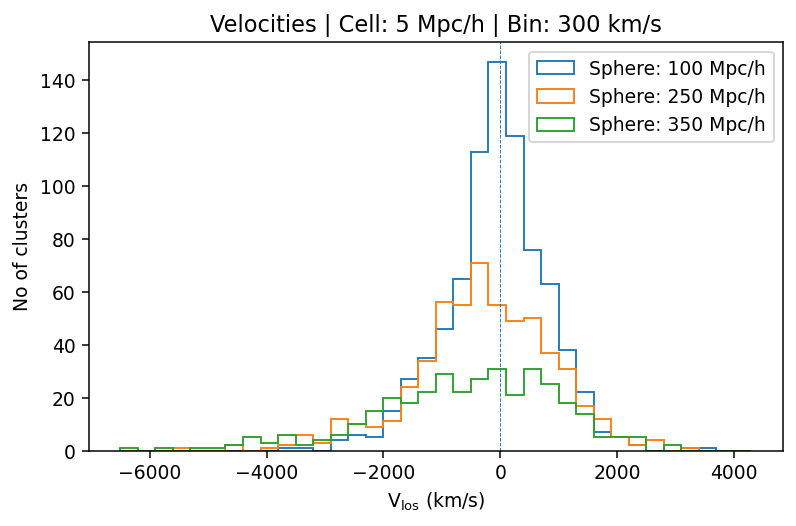

In [49]:
x_min = min(df_clus_100_5000['v_los_est[km/s]'].min(),
            df_clus_250_5000['v_los_est[km/s]'].min(),
            df_clus_350_5000['v_los_est[km/s]'].min())

x_max = max(df_clus_100_5000['v_los_est[km/s]'].max(),
            df_clus_250_5000['v_los_est[km/s]'].max(),
            df_clus_350_5000['v_los_est[km/s]'].max())

bin_size = 300
bins = np.arange(x_min, x_max, bin_size)

plt.figure(dpi = dpi*1.5)

plt.hist(df_clus_100_5000['v_los_est[km/s]'], bins = bins,
         label = 'Sphere: 100 Mpc/h', histtype = 'step')
plt.hist(df_clus_250_5000['v_los_est[km/s]'], bins = bins,
         label = 'Sphere: 250 Mpc/h', histtype = 'step')
plt.hist(df_clus_350_5000['v_los_est[km/s]'], bins = bins,
         label = 'Sphere: 350 Mpc/h', histtype= 'step')
# freq_100, bins_100 = np.histogram(df_clus_100_5000['v_los_est[km/s]'], bins = bins)
# plt.plot(freq_100, bins_100[:-1] + (bins_100[1]))

plt.legend()

plt.xlabel('V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('No of clusters')

plt.axvline(x = 0, ls = 'dashed', lw = 0.5)

plt.title(f'Velocities | Cell: 5 Mpc/h | Bin: {bin_size} km/s');

plt.tight_layout()
# plt.savefig('Plots/Practice_Talk/real_vels_5Mpc.pdf')cv

**17 Nov 2021**  
B:  
- Paper using BOSS data is saying a mismatch in average number of counts as function of redshift b/w north and south gaps up to z < 0.5 (exactly ~ 0.47). From z > 0.5, the two gaps overlap each other.
- This should translate into a bias in velocity reconstruction.
- **Task**: Let's give z into 0.30 - 0.45 and 0.45 - 0.60, and check the deviation (in vel histogram). Lower redshift part should have higher deviation.
- **Task**: Make sure SDSS redshifts are in heliocentric, and then convert them into galactocentric and obtain velocity histograms. If clusters are only present in part of the sky (BN region), motion of sun will not give a smooth shift, it will random.
- **Task**: Also plot the clusters positions in galactic coordinates.

552141.756456439


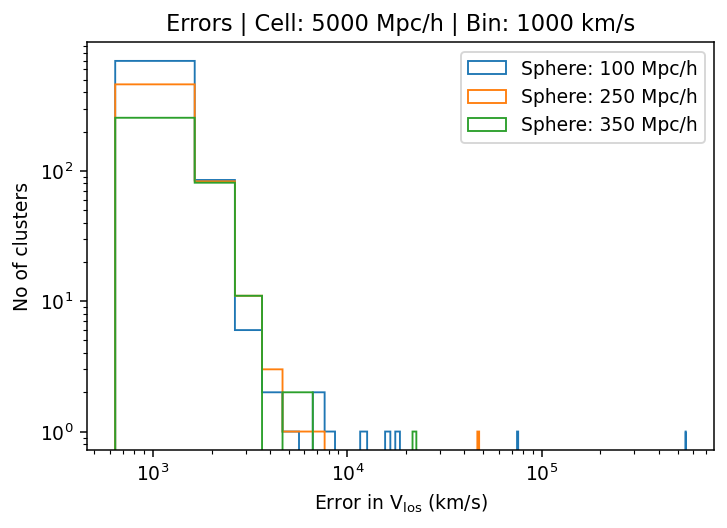

In [58]:
x_min = min(df_clus_100_5000['v_los_est_err[km/s]'].min(),
            df_clus_250_5000['v_los_est_err[km/s]'].min(),
            df_clus_350_5000['v_los_est_err[km/s]'].min())

x_max = max(df_clus_100_5000['v_los_est_err[km/s]'].max(),
            df_clus_250_5000['v_los_est_err[km/s]'].max(),
            df_clus_350_5000['v_los_est_err[km/s]'].max())

print(x_max)

bin_size = 1000
bins = np.arange(x_min, x_max, bin_size)

plt.figure(dpi = dpi*1.5)

plt.hist(df_clus_100_5000['v_los_est_err[km/s]'], histtype = 'step', bins = bins,
         label = 'Sphere: 100 Mpc/h')
plt.hist(df_clus_250_5000['v_los_est_err[km/s]'], histtype = 'step', bins = bins,
         label = 'Sphere: 250 Mpc/h')
plt.hist(df_clus_350_5000['v_los_est_err[km/s]'], histtype = 'step', bins = bins,
         label = 'Sphere: 350 Mpc/h')
plt.legend()

plt.xlabel('Error in V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('No of clusters')

plt.xscale('log')
plt.yscale('log')

# plt.xlim(1e2,)

plt.title(f'Errors | Cell: 5000 Mpc/h | Bin: {bin_size} km/s');

In [35]:
skew_kurtosis = pd.DataFrame()


df_clus_100_10000 = pd.read_csv('Data/with_vels/z_gt_3_lt_6_100_10000.csv')
skew_kurtosis = skew_kurtosis.append({'Sphere': 100, 
                                      'Skewness' : df_clus_100_10000['v_los_est[km/s]'].skew(),
                                      'Kurtosis' : df_clus_100_10000['v_los_est[km/s]'].kurtosis()}, 
                                     ignore_index=True)

df_clus_250_10000 = pd.read_csv('Data/with_vels/z_gt_3_lt_6_250_10000.csv')
skew_kurtosis = skew_kurtosis.append({'Sphere': 250, 
                                      'Skewness' : df_clus_250_10000['v_los_est[km/s]'].skew(),
                                      'Kurtosis' : df_clus_250_10000['v_los_est[km/s]'].kurtosis()}, 
                                     ignore_index=True)

df_clus_350_10000 = pd.read_csv('Data/with_vels/z_gt_3_lt_6_350_10000.csv')
skew_kurtosis = skew_kurtosis.append({'Sphere': 350, 
                                      'Skewness' : df_clus_350_10000['v_los_est[km/s]'].skew(),
                                      'Kurtosis' : df_clus_350_10000['v_los_est[km/s]'].kurtosis()}, 
                                     ignore_index=True)

skew_kurtosis

Sphere  Skewness  Kurtosis
0   100.0  0.097941  0.998569
1   250.0 -0.094586  0.418040
2   350.0 -0.510329 -0.150465

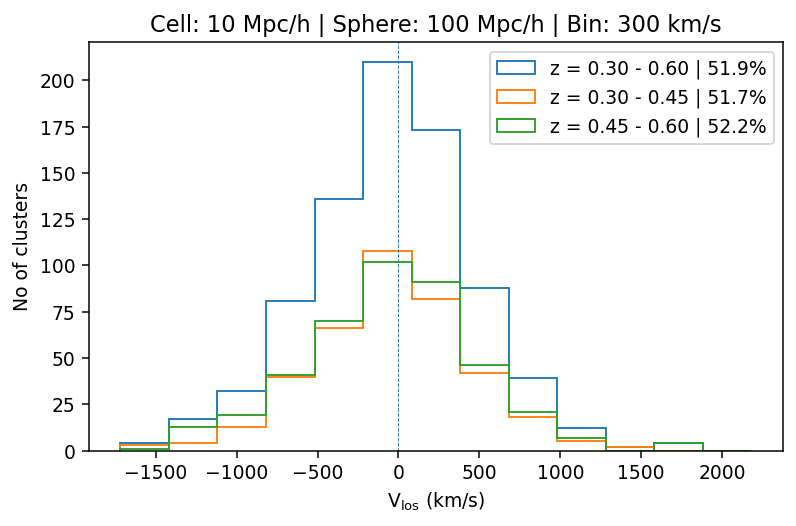

In [130]:
x_min = (df_clus_100_10000['v_los_est[km/s]'].min())

x_max = (df_clus_100_10000['v_los_est[km/s]'].max())

bin_size = 300
bins = np.arange(x_min, x_max, bin_size)

plt.figure(dpi = dpi*1.5)

neg_percent = (len(df_clus_100_10000[df_clus_100_10000['v_los_est[km/s]'] < 0]) / 
               len(df_clus_100_10000['v_los_est[km/s]'])) * 100
plt.hist(df_clus_100_10000['v_los_est[km/s]'], bins = bins,
         label = 'z = 0.30 - 0.60 | ' + str(round(neg_percent, 1)) + '%', histtype = 'step')

neg_percent = (len(df_clus_100_10000[(df_clus_100_10000['redshift'] < 0.45) &
                                    (df_clus_100_10000['v_los_est[km/s]'] < 0)]) / 
               len(df_clus_100_10000[df_clus_100_10000['redshift'] < 0.45]['v_los_est[km/s]'])) * 100
plt.hist(df_clus_100_10000[df_clus_100_10000['redshift'] < 0.45]['v_los_est[km/s]'], bins = bins,
         label = 'z = 0.30 - 0.45 | ' + str(round(neg_percent, 1)) + '%', histtype = 'step')

neg_percent = (len(df_clus_100_10000[(df_clus_100_10000['redshift'] > 0.45) &
                                    (df_clus_100_10000['v_los_est[km/s]'] < 0)]) / 
               len(df_clus_100_10000[df_clus_100_10000['redshift'] > 0.45]['v_los_est[km/s]'])) * 100
plt.hist(df_clus_100_10000[df_clus_100_10000['redshift'] > 0.45]['v_los_est[km/s]'], bins = bins,
         label = 'z = 0.45 - 0.60 | ' + str(round(neg_percent, 1)) + '%', histtype = 'step')

plt.legend()

plt.xlabel('V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('No of clusters')

plt.axvline(x = 0, ls = 'dashed', lw = 0.5)

plt.title(f'Cell: 10 Mpc/h | Sphere: 100 Mpc/h | Bin: {bin_size} km/s');

plt.tight_layout()
# plt.savefig('Plots/Practice_Talk/real_vels_5Mpc.pdf')cv

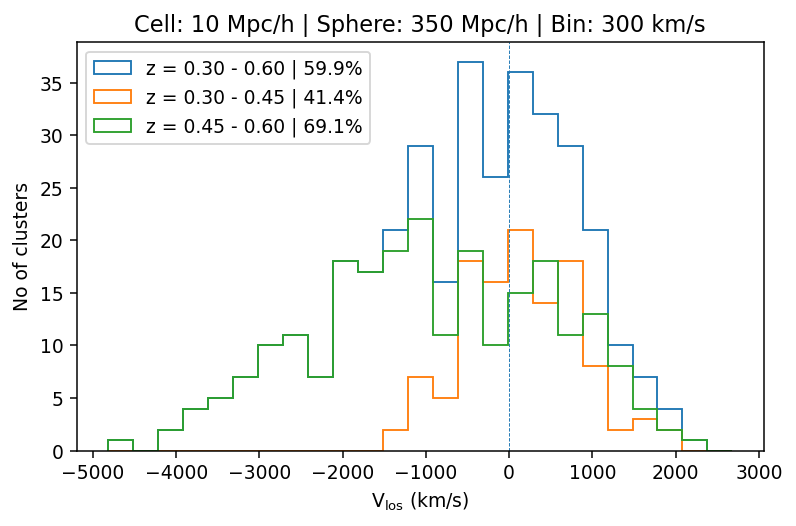

In [129]:
x_min = (df_clus_350_10000['v_los_est[km/s]'].min())

x_max = (df_clus_350_10000['v_los_est[km/s]'].max())

bin_size = 300
bins = np.arange(x_min, x_max, bin_size)

plt.figure(dpi = dpi*1.5)

neg_percent = (len(df_clus_350_10000[df_clus_350_10000['v_los_est[km/s]'] < 0]) / 
               len(df_clus_350_10000['v_los_est[km/s]'])) * 100
plt.hist(df_clus_350_10000['v_los_est[km/s]'], bins = bins,
         label = 'z = 0.30 - 0.60 | ' + str(round(neg_percent, 1)) + '%', histtype = 'step')

neg_percent = (len(df_clus_350_10000[(df_clus_350_10000['redshift'] < 0.45) &
                                    (df_clus_350_10000['v_los_est[km/s]'] < 0)]) / 
               len(df_clus_350_10000[df_clus_350_10000['redshift'] < 0.45]['v_los_est[km/s]'])) * 100
plt.hist(df_clus_350_10000[df_clus_350_10000['redshift'] < 0.45]['v_los_est[km/s]'], bins = bins,
         label = 'z = 0.30 - 0.45 | ' + str(round(neg_percent, 1)) + '%', histtype = 'step')

neg_percent = (len(df_clus_350_10000[(df_clus_350_10000['redshift'] > 0.45) &
                                    (df_clus_350_10000['v_los_est[km/s]'] < 0)]) / 
               len(df_clus_350_10000[df_clus_350_10000['redshift'] > 0.45]['v_los_est[km/s]'])) * 100
plt.hist(df_clus_350_10000[df_clus_350_10000['redshift'] > 0.45]['v_los_est[km/s]'], bins = bins,
         label = 'z = 0.45 - 0.60 | ' + str(round(neg_percent, 1)) + '%', histtype = 'step')

plt.legend()

plt.xlabel('V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('No of clusters')

plt.axvline(x = 0, ls = 'dashed', lw = 0.5)

plt.title(f'Cell: 10 Mpc/h | Sphere: 350 Mpc/h | Bin: {bin_size} km/s');

plt.tight_layout()
# plt.savefig('Plots/Practice_Talk/real_vels_5Mpc.pdf')cv

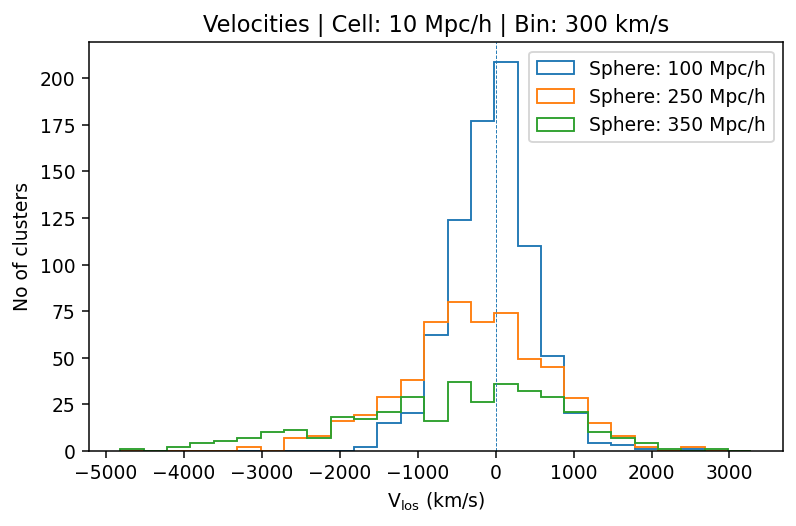

In [54]:
x_min = min(df_clus_100_10000['v_los_est[km/s]'].min(),
            df_clus_250_10000['v_los_est[km/s]'].min(),
            df_clus_350_10000['v_los_est[km/s]'].min())

x_max = max(df_clus_100_10000['v_los_est[km/s]'].max(),
            df_clus_250_10000['v_los_est[km/s]'].max(),
            df_clus_350_10000['v_los_est[km/s]'].max())

bin_size = 300
bins = np.arange(x_min, x_max, bin_size)

plt.figure(dpi = dpi*1.5)

plt.hist(df_clus_100_10000['v_los_est[km/s]'], histtype = 'step', bins = bins,
         label = 'Sphere: 100 Mpc/h')
plt.hist(df_clus_250_10000['v_los_est[km/s]'], histtype = 'step', bins = bins,
         label = 'Sphere: 250 Mpc/h')
plt.hist(df_clus_350_10000['v_los_est[km/s]'], histtype = 'step', bins = bins,
         label = 'Sphere: 350 Mpc/h')
plt.legend()

plt.xlabel('V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('No of clusters')

plt.axvline(x = 0, ls = 'dashed', lw = 0.5)
plt.title(f'Velocities | Cell: 10 Mpc/h | Bin: {bin_size} km/s');

plt.tight_layout()
# plt.savefig('Plots/Practice_Talk/real_vels_10Mpc.pdf')

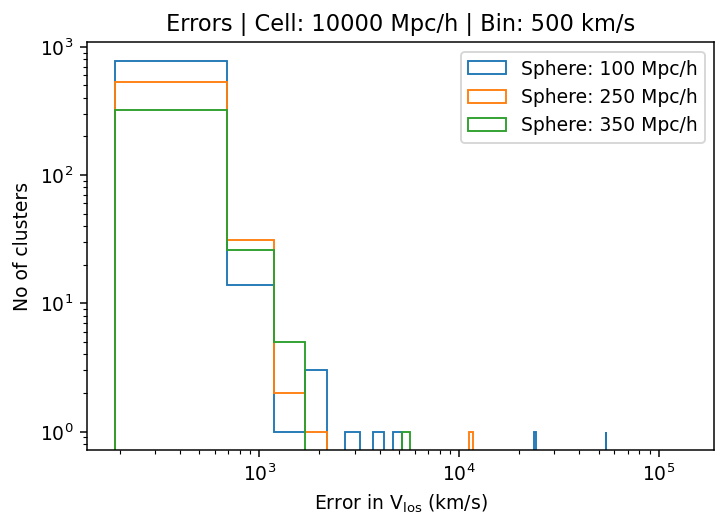

In [59]:
x_min = min(df_clus_100_10000['v_los_est_err[km/s]'].min(),
            df_clus_250_10000['v_los_est_err[km/s]'].min(),
            df_clus_350_10000['v_los_est_err[km/s]'].min())

x_max = max(df_clus_100_10000['v_los_est_err[km/s]'].max(),
            df_clus_250_10000['v_los_est_err[km/s]'].max(),
            df_clus_350_10000['v_los_est_err[km/s]'].max())

bin_size = 500
bins = np.arange(x_min, x_max, bin_size)

plt.figure(dpi = dpi*1.5)

plt.hist(df_clus_100_10000['v_los_est_err[km/s]'], histtype = 'step', bins = bins,
         label = 'Sphere: 100 Mpc/h')
plt.hist(df_clus_250_10000['v_los_est_err[km/s]'], histtype = 'step', bins = bins,
         label = 'Sphere: 250 Mpc/h')
plt.hist(df_clus_350_10000['v_los_est_err[km/s]'], histtype = 'step', bins = bins,
         label = 'Sphere: 350 Mpc/h')
plt.legend()

plt.xlabel('Error in V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('No of clusters')

plt.xscale('log')
plt.yscale('log')

# plt.xlim(1e2,)

plt.title(f'Errors | Cell: 10000 Mpc/h | Bin: {bin_size} km/s');